## <div class="alert alert-info"><h1>Imports</h1></div>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import lightgbm as lgb
import sklearn
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
from sklearn.feature_selection import VarianceThreshold
import datetime

#Start a timer to check the execution time of the notebook.
start_time = time.time()

## <div class="alert alert-info"><h1>Function Definitions</h1></div>

In [2]:
#Calculate the R^2 as defined above
def r_squared(y, ypred):
    """R-squared score.
    
    Calculate the R-squared, or coefficient of determination, of the input.
    
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y) #yes, we could use np.mean(y)
    sum_sq_tot = np.sum((y - ybar)**2) #total sum of squares error
    sum_sq_res = np.sum((y - ypred)**2) #residual sum of squares error
    R2 = 1.0 - sum_sq_res / sum_sq_tot 
    return R2

This is very simply the average of the absolute errors:

$$MAE = \frac{1}{n}\sum_i^n|y_i - \hat{y}|$$

In [3]:
#Calculate the MAE as defined above
def mae(y, ypred):
    """Mean absolute error.
    
    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

Another common metric (and an important one internally for optimizing machine learning models) is the mean squared error. This is simply the average of the square of the errors:

$$MSE = \frac{1}{n}\sum_i^n(y_i - \hat{y})^2$$

In [4]:
#Calculate the MSE as defined above
def mse(y, ypred):
    """Mean square error.
    
    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

## <div class="alert alert-info"><h1>Load the Data</h1></div>

In [5]:
datapath = '../data/health_cdc_data_EDA_features.csv'
health_rec = pd.read_csv(datapath)

In [6]:
health_rec.head()

,region,state,city,total_days_of_care,total_charges,total_cases,min_copay_for_new_patient,max_copay_for_new_patient,mode_copay_for_new_patient,min_copay_for_established_patient,...,hearingdf,state_total_hispallp,occupation_per_100kcapita,occupation_per_100ksq_mile,race_ratio,access_ratio,discrimination_ratio,vigilance_ratio,sex_ratio,hispanic_ratio
0,south,south carolina,Sumter,16460.0,131894850.0,3156.0,120.562500,368.75000,187.125000,38.187500,...,1.0,31606,0.718626,115.552780,0.000041,0.000057,0.000083,0.000075,0.000091,0.000063
1,south,texas,Huffman,527.0,7650966.0,72.0,43.687500,132.75000,67.812500,13.953125,...,1.0,106227,0.127604,13.775335,0.000025,0.000017,0.000025,0.000022,0.000027,0.000028
2,south,oklahoma,Oktaha,220.0,2020002.0,58.0,13.250000,40.65625,20.609375,4.171875,...,1.0,34405,0.909787,51.502883,0.000038,0.000052,0.000076,0.000069,0.000041,0.000058
3,midwest,minnesota,Zumbrota,49.0,321551.0,13.0,14.000000,42.06250,21.453125,4.578125,...,1.0,27092,0.656071,42.560044,0.000060,0.000067,0.000098,0.000085,0.000051,0.000074
4,south,texas,Hubbard,242.0,2751082.0,50.0,13.710938,41.71875,21.234375,4.382812,...,1.0,106227,0.127604,13.775335,0.000012,0.000017,0.000025,0.000022,0.000027,0.000019


In [7]:
# Drop all columns that start with 'state_total_', 'min_' or 'max_'
health_rec = health_rec.drop(columns=[col for col in health_rec.columns if col.startswith(('state_total_','min_', 'max_'))])
health_rec = health_rec.drop('aggregation_level',axis=1)
health_rec.shape

(621951, 37)

<div class="alert alert-info"><strong>Extracting Black race from the rest of the data</strong></div>

<div style="background-color: rgba(128, 0, 128, 0.7); padding: 10px; color: white;"> Race definition:<br>
1 White<br> 
2 Black/African American <br>
3 Asian <br>
4 AIAN <br>
5 AIAN and any other group <br>
6 Other single and multiple races <br>
7 Refused <br>
8 Not Ascertained<br>
9 Don't know

<div style="background-color: rgba(128, 0, 128, 0.7); padding: 10px; color: white;"> Hispanic definition:<br>
1 Hispanic <br>
2 Non-Hispanic White only <br>
3 Non-Hispanic Black/African American only <br>
4 Non-Hispanic Asian only <br>
5 Non-Hispanic AIAN only <br>
6 Non-Hispanic AIAN and any other group <br>
7 Other single and multiple races <br>

In [8]:
# Filter cases where hispanic == 3 and race is NOT 2
non_matching_rows = health_rec[(health_rec['hispanic'] == 3) & (health_rec['race'] != 2)]

# Check if such cases exist
if not non_matching_rows.empty:
    print("There are cases where hispanic == 3 but race is NOT 2.")
    print(non_matching_rows)
else:
    print("All cases where hispanic == 3 have race == 2.")

All cases where hispanic == 3 have race == 2.


<div class="alert alert-info">First we check if hispanic column black and race column black are always the same.<br>
The result shows we can focus on filtering by race only<br><br>
We will consider doing the same exercice by extractic all Hispanic</div>

In [9]:
blk_race = health_rec[health_rec.race == 2]

In [10]:
blk_race.head().T

,1,8,20,24,26
region,south,south,south,south,south
state,texas,west virginia,alabama,louisiana,maryland
city,Huffman,Harrisville,Moulton,Monroe,Dunkirk
total_days_of_care,527.0,180.0,692.0,7701.0,112.0
total_charges,7650966.0,2777041.0,12128407.0,76742790.0,544773.0
total_cases,72.0,28.0,141.0,979.0,11.0
mode_copay_for_new_patient,67.8125,20.875,40.9375,209.0,22.4375
mode_copay_for_established_patient,77.0625,23.703125,46.875,237.75,25.53125
total_agi,1939422.0,78047.0,710862.0,6942040.0,468760.0
race,2.0,2.0,2.0,2.0,2.0


In [11]:
health_rec.shape

(621951, 37)

In [12]:
health_rec = health_rec[health_rec.race !=2]

In [13]:
health_rec.shape

(540150, 37)

<div class="alert alert-info">We will do feature selection to reduced health_rec columns<br>
   
</div>

In [14]:
constant_columns = [col for col in health_rec.columns if health_rec[col].nunique() == 1]
health_rec = health_rec.drop(columns=constant_columns)
# Separate numerical and object features
numerical_features = health_rec.select_dtypes(include=['number'])
object_features = health_rec.select_dtypes(include=['object'])

# Apply VarianceThreshold to numerical features only
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
selector.fit(numerical_features)

# Get the selected numerical features
selected_numerical_features = numerical_features.columns[selector.get_support(indices=True)]

# Combine selected numerical features with object features
health_rec_selected = pd.concat([health_rec[selected_numerical_features], object_features], axis=1)

# Update health_rec with the selected features
health_rec = health_rec_selected
health_rec.shape

(540150, 30)

<div class="alert alert-info">We have reduced the health_rec by 81,801 rows and 7 columns.<br>
    This is not enough as run time was 8-20 minutes.<br><br>
    Reducing health_rec by 80%<br>
    This might be risky.
</div>

In [15]:
health_rec_saved = health_rec
# Randomly sample 20% of the rows
health_rec = health_rec.sample(frac=0.2, random_state=42) #random_state added for reproducibility.

print("Original DataFrame shape:", health_rec_saved.shape)
print("Reduced DataFrame shape:", health_rec.shape)
print("\nReduced DataFrame: health_rec")

Original DataFrame shape: (540150, 30)
Reduced DataFrame shape: (108030, 30)

Reduced DataFrame: health_rec


<div class="alert alert-info">Train/Test Split.<br>
    <br> Since we have a large data set, we will start with a 50/50 train/test split.
    <br> Let's check the particition size
</div>

In [16]:
len(health_rec) * .5 , len(health_rec) * .5 

(54015.0, 54015.0)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(health_rec.drop(columns='access'), 
                                                    health_rec.access, test_size=0.5, 
                                                    random_state=47)

In [18]:
X_train.shape, X_test.shape

((54015, 29), (54015, 29))

In [19]:
y_train.shape, y_test.shape

((54015,), (54015,))

In [20]:
#Save the 'region', state',and 'city' columns from the train/test data into names_train and names_test
#Then drop those columns from `X_train` and `X_test`
names_list = ['region', 'state', 'city']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((54015, 26), (54015, 26))

In [21]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

total_days_of_care                    float64
total_charges                         float64
total_cases                           float64
mode_copay_for_new_patient            float64
mode_copay_for_established_patient    float64
total_agi                             float64
race                                  float64
hispanic                              float64
sex                                   float64
discrimination                        float64
vigilance                             float64
gtgrisk                               float64
wellness                              float64
paillmb3m                             float64
marital                               float64
medicare                              float64
mhthrpy                               float64
discrim3                              float64
hisdetp                               float64
citznstp                              float64
ecigev                                float64
ahearst1                          

In [22]:
#Repeat this check for the test split in `X_test`
X_test.dtypes

total_days_of_care                    float64
total_charges                         float64
total_cases                           float64
mode_copay_for_new_patient            float64
mode_copay_for_established_patient    float64
total_agi                             float64
race                                  float64
hispanic                              float64
sex                                   float64
discrimination                        float64
vigilance                             float64
gtgrisk                               float64
wellness                              float64
paillmb3m                             float64
marital                               float64
medicare                              float64
mhthrpy                               float64
discrim3                              float64
hisdetp                               float64
citznstp                              float64
ecigev                                float64
ahearst1                          

<div class="alert alert-info">Let's assume the average access is the the best guess
</div>

In [23]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

np.float64(1.1932611311672683)

<div class="alert alert-info">Let's repeat this with sklearn's DummyRegressor
</div>

In [24]:
#Fit the dummy regressor on the training data
#Hint, call its `.fit()` method with `X_train` and `y_train` as arguments
#Then print the object's `constant_` attribute and verify it's the same as the mean above
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[1.19326113]])

<div class="alert alert-info">Pretty close
</div>

<div class="alert alert-info"><strong>Metrics Analysis</strong><br><br>
    We will make your predictions by creating an array of length the size of the training set with the single value of the mean.
</div>

In [25]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([1.19326113, 1.19326113, 1.19326113, 1.19326113, 1.19326113])

In [26]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([1.19326113, 1.19326113, 1.19326113, 1.19326113, 1.19326113])

<div class="alert alert-info">Dummy regression produces the exact same result
</div>

In [27]:
r_squared(y_train, y_tr_pred)

np.float64(0.0)

<div class="alert alert-info">We will predict by creating an array of length the size of the test set with the single value of the (training) mean.
</div>

In [28]:
y_te_pred = train_mean * np.ones(len(y_test))
r_squared(y_test, y_te_pred)

np.float64(-1.624942519384831e-05)

<div class="alert alert-info">Calculating Mean Absolute Error
</div>

In [29]:
mae(y_train, y_tr_pred)

np.float64(0.3386282791482911)

In [30]:
mae(y_test, y_te_pred)

np.float64(0.34094048617996536)

<div class="alert alert-info">Calculating Mean Squared Error
</div>

In [31]:
mse(y_train, y_tr_pred)

np.float64(0.5483948357260924)

In [32]:
mse(y_test, y_te_pred)

np.float64(0.5535671655141476)

<div class="alert alert-info">The Mean Squared Error on the test set is worst than the train set. <br>
    Let's check the root mean square error. 
</div>

In [33]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([0.74053686, 0.74402094])

<div class="alert alert-info">Using sklearn metrics<br>
    R-squared<br>
    Mean Absolute Error<br>
    Mean Squared Error
</div>

In [34]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -1.624942519384831e-05)

In [35]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.3386282791482911, 0.34094048617996536)

In [36]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(0.5483948357260924, 0.5535671655141476)

In [37]:
X_train.head()

,total_days_of_care,total_charges,total_cases,mode_copay_for_new_patient,mode_copay_for_established_patient,total_agi,race,hispanic,sex,discrimination,...,mhthrpy,discrim3,hisdetp,citznstp,ecigev,ahearst1,depev,hearingdf,occupation_per_100kcapita,occupation_per_100ksq_mile
491165,136.0,1351965.0,29.0,20.734375,23.859375,50622.0,1.0,2.0,1.0,5.0,...,2.0,5.0,3.0,1.0,2.0,1.0,2.0,1.0,0.635473,56.492000
224358,919.0,6059290.0,220.0,40.781250,46.812500,472694.0,1.0,2.0,2.0,4.0,...,2.0,5.0,3.0,2.0,2.0,1.0,2.0,1.0,0.527150,85.421412
453434,323.0,7990706.0,59.0,20.468750,23.437500,74001.0,1.0,2.0,2.0,3.0,...,1.0,3.0,3.0,1.0,2.0,1.0,1.0,1.0,0.734217,68.676078
278694,204.0,2619066.0,40.0,21.187500,24.109375,60659.0,1.0,1.0,2.0,8.0,...,8.0,8.0,1.0,8.0,8.0,8.0,2.0,1.0,0.316534,82.541382
502815,399.0,6497332.0,66.0,21.453125,24.656250,1748410.0,1.0,2.0,1.0,4.0,...,2.0,4.0,3.0,1.0,2.0,2.0,1.0,1.0,0.656071,42.560044


In [38]:
xtrain = X_train.isnull().sum()
xtest = X_test.isnull().sum()
xtrain.head(), xtest.head()

(total_days_of_care                    0
 total_charges                         0
 total_cases                           0
 mode_copay_for_new_patient            0
 mode_copay_for_established_patient    0
 dtype: int64,
 total_days_of_care                    0
 total_charges                         0
 total_cases                           0
 mode_copay_for_new_patient            0
 mode_copay_for_established_patient    0
 dtype: int64)

<div class="alert alert-info">Our data does not require any imputation 
</div>

<div class="alert alert-info">Time to scale the data
</div>

In [39]:
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

<div class="alert alert-info">We will train the model on the train set<br><br>
    Linear Regression Model
</div>

In [40]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

<div class="alert alert-info">We will make predictions using the model on both train and test splits
</div>

In [41]:
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [42]:
# r^2 - train, test
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.3198139549638306, 0.31696042168465866)

<div class="alert alert-info">The model explains approximately 31.98% of the variance in the target variable within the training data.<br>
    It explains approximately 31.70% of the variance in the target variable within the test data.<br>
    This represents a moderate fit with room for improvement. The model is capturing a signiticant portion of the variability in the target. 
</div>

In [43]:
#Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(0.31682623167010804, 0.3207280283066801)

<div class="alert alert-info">The model predictions are only off by about 0.26. Since they are both close together, th emodel is generalizing the unseen data well.<br>
    It is likely that the model is not overfitting.
</div>

In [44]:
#And also do the same using `sklearn`'s `mean_squared_error`
# MSE - train, test
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(0.37301051443079053, 0.37810213935957304)

<div class="alert alert-info">We will use sklearn's Pipeline
</div>

In [45]:
#Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=15),
    LinearRegression()
)

In [46]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x000001E51FAA8B80>)),
                ('linearregression', LinearRegression())])

In [47]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [48]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.3175791827911215, 0.31525179192579766)

In [49]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.3170881460878751, 0.3209906106966253)

In [50]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(0.3742360519493286, 0.3790479653229706)

<div class="alert alert-info">Pipeline seems slightly worse. <br><br>
    Assessing performance using cross-validation is not necessary for linear regression
</div>

<div class="alert alert-warning">Turning the following few cells to markdown. <br>
    #cv = 3
#cv_results = cross_validate(pipe15, X_train, y_train, cv=cv)</div>

<div class="alert alert-warning">cv_scores = cv_results['test_score']
cv_scores<div></div>

<div class="alert alert-warning">np.mean(cv_scores), np.std(cv_scores)</div>

<div class="alert alert-warning">np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)</div>

<div class="alert alert-info">
    <strong>Hyperparameter search using GridSearchCV<strong>
</div>

In [51]:
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe15.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__keep_empty_features', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

In [52]:
len(X_train)

54015

In [53]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [54]:
cv=3
lr_grid_cv = GridSearchCV(pipe15, param_grid=grid_params, cv=cv, n_jobs=-1)

In [55]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(k=15,
                                                    score_func=<function f_regression at 0x000001E51FAA8B80>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26]})

In [56]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [57]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 18}

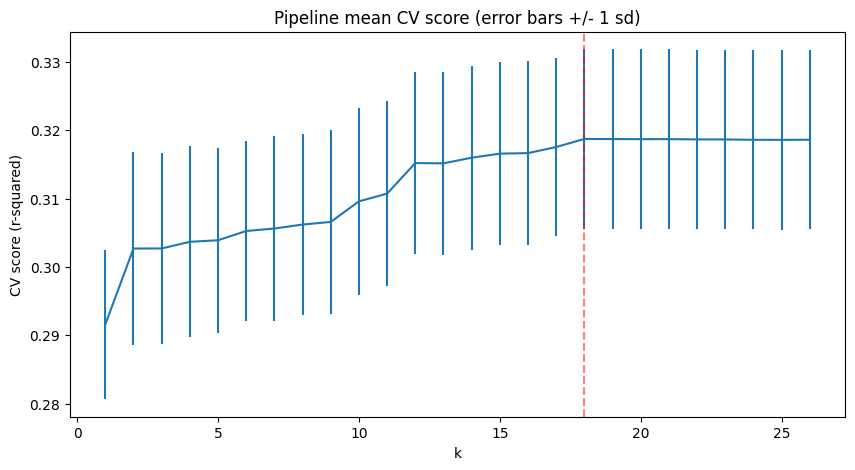

In [58]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1 sd)');

<div class="alert alert-info">
    <strong>The best k is 18. With the full data set it was at 38.</strong><br>
        The error bars are about the same size for all K. This greater variability could lead to overfitting<br>
    We will plot again by applying a stability threshold. This might not be needed with 20% the data set.
</div>

In [59]:
# Find the smallest k that is within 95% of the max score
max_score = max(score_mean)
threshold = 0.95 * max_score

# Find the smallest k that meets the threshold
optimal_k = min(k for k, score in zip(cv_k, score_mean) if score >= threshold)

print(f"Optimal k based on thresholding: {optimal_k}")


Optimal k based on thresholding: 4


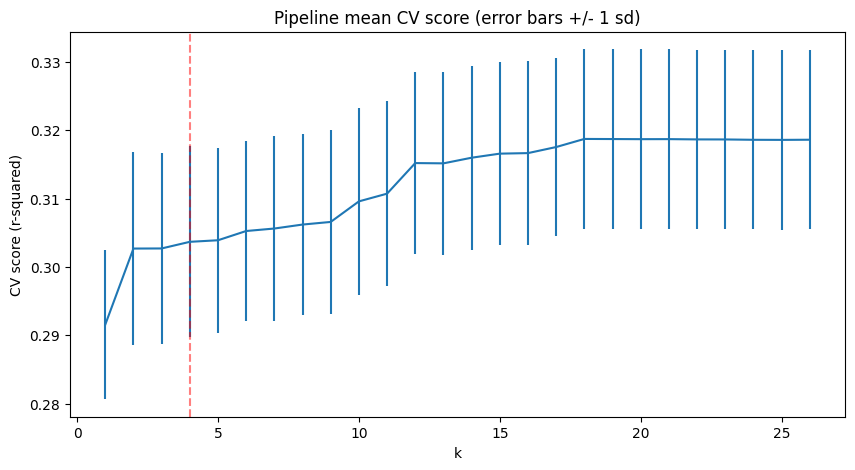

In [60]:
#Assign the value of k from the above 'optimal_k` and assign it to `best_k`
best_k = optimal_k
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1 sd)');

In [61]:
print(f"Max CV Score: {max(score_mean)}")
print(f"Score at k=18: {score_mean[cv_k.index(18)]}")

Max CV Score: 0.3187171198455717
Score at k=18: 0.3187171198455717


<div class="alert alert-info">
    We will manually set and refit SelectKBest to use K =12 intead of best_param_ k =18<br>
    This is where the CV score starts to flatten
</div>

In [62]:
# Get the feature selector and override k
selector = lr_grid_cv.best_estimator_.named_steps.selectkbest
selector.set_params(k=12)
X_selected = selector.fit_transform(X_train, y_train)  # Refit with k=12

#Rebuild the pipeline with k=12
best_model = lr_grid_cv.best_estimator_
best_model.named_steps.selectkbest = selector
best_model.fit(X_train, y_train)  # Refit entire pipeline


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=12,
                             score_func=<function f_regression at 0x000001E51FAA8B80>)),
                ('linearregression', LinearRegression())])

In [63]:
selected = selector.get_support()

In [64]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = best_model.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_index(ascending=True)

ahearst1         -0.015547
citznstp          0.008707
discrim3         -0.002345
discrimination   -0.017812
ecigev            0.005597
gtgrisk           0.316972
marital           0.031111
medicare          0.053557
mhthrpy           0.103894
paillmb3m        -0.017874
vigilance        -0.012591
wellness         -0.044314
dtype: float64

<div class="alert alert-info">
   gtgrisk describes if a patient had genetic cancer testing in the past. This has the largest positive effect. <br>
    This suggests better access when a person is proactive in their screening<br>
    <strong>On the negative side, the coefficients of the influences are small. They slightly impact the outcome of the target.</strong>
</div>

<div class="alert alert-info">
    <strong>Let's explore Random Forest Model</strong><br>

</div>

In [65]:
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),RandomForestRegressor
    (random_state=47)
)

<div class="alert alert-info">
   Fit and assess performance with cross-validation<br>

</div>

In [66]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe,X_train, y_train, cv=cv)

In [67]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.8864821 , 0.86221468, 0.89735669])

In [68]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(np.float64(0.8820178235116997), np.float64(0.01468985036511917))

<div class="alert alert-info">
  <strong>Hyperparameter search using GridSearchCV</strong>

</div>

In [69]:
#n_est = [int(n) for n in np.logspace(start=1.5, stop=3, num=10)] # this is proving to be a challenging task. Running the next cell is taking longer than 10 minutes at time 1 hour
n_est = [50,100,500,1000]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [None], # Skip scaling since RF handles unscaled data well
        'simpleimputer__strategy': ['mean', 'median']
}

grid_params

{'randomforestregressor__n_estimators': [50, 100, 500, 1000],
 'standardscaler': [None],
 'simpleimputer__strategy': ['mean', 'median']}

In [70]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=cv, n_jobs=4)

In [71]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=4,
             param_grid={'randomforestregressor__n_estimators': [50, 100, 500,
                                                                 1000],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [None]})

In [72]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

<div class="alert alert-info">


  Before we continue, let's determine if 1000 trees are needed by plottingg mean cv score vs n_estimators

</div>

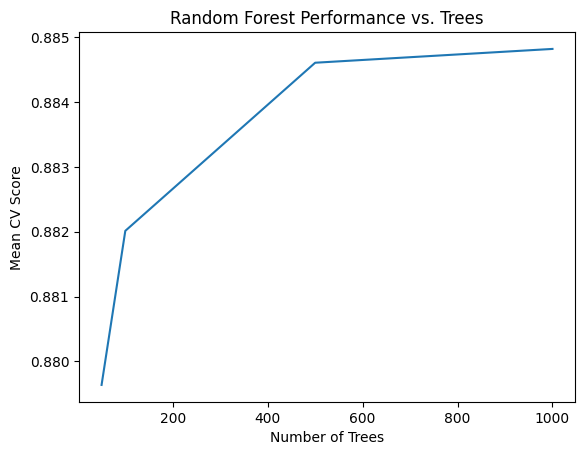

In [73]:
# Instead of assuming 1000 is best, let’s check if it’s worth keeping by:
# Comparing Model Performance for n_estimators=[50, 100, 500, 1000]
results = rf_grid_cv.cv_results_
plt.plot(results['param_randomforestregressor__n_estimators'], results['mean_test_score'])
plt.xlabel('Number of Trees')
plt.ylabel('Mean CV Score')
plt.title('Random Forest Performance vs. Trees')
plt.show()

<div class="alert alert-info">
  100 → 500 trees only increased the score by 0.002 (0.2%).<br>
After 500 trees increased, the scores starts to flatten<br>
More trees produce diminishing return.<br><br>

We will redo the fit by removing 1000 trees from grid_params

</div>

In [74]:
n_est = [50,100,500]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [None], # Skip scaling since RF handles unscaled data well
        'simpleimputer__strategy': ['mean', 'median']
}

grid_params

{'randomforestregressor__n_estimators': [50, 100, 500],
 'standardscaler': [None],
 'simpleimputer__strategy': ['mean', 'median']}

In [75]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=cv, n_jobs=4)

In [76]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=4,
             param_grid={'randomforestregressor__n_estimators': [50, 100, 500],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [None]})

In [77]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 500,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

<div class="alert alert-info">
Much faster execution. 

  Imputing with mean helps but this is not very meaningful since the data did not have any NaN.<br>
  The best number of trees for our data is 500 (n_estimators). We already know more than 500 has diminishing returns<br>
  scaling had no affect<br><br>
</div>

In [78]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.90705704, 0.90551438, 0.87904697, 0.90296144, 0.91076724])

In [79]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(np.float64(0.9010694152857566), np.float64(0.011298010287992936))

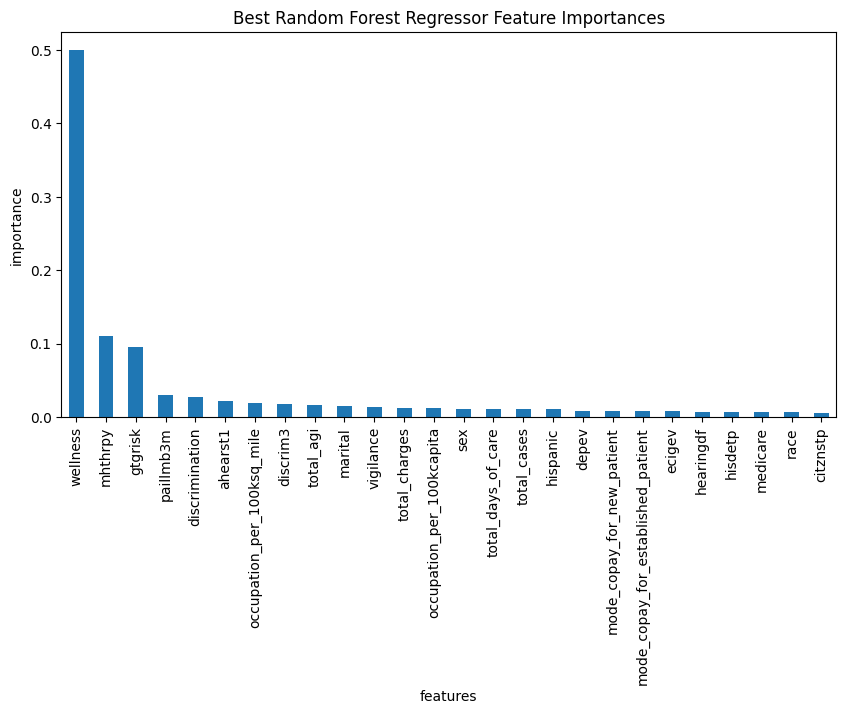

In [80]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best Random Forest Regressor Feature Importances');

<div class="alert alert-info">
Nice to see gtgrisk is still in the top list<br><br>
    We will try one more model, Gradient Boosting, specifically LightGBM
</div>

In [81]:
 # or LGBMClassifier()
lgbm_model = lgb.LGBMRegressor(verbose=-1) #verbose used to remove warnings from the display

In [82]:
lgbm_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.002, 0.0005]    
}

In [83]:
lgbm_grid_cv = GridSearchCV(lgbm_model, param_grid=lgbm_params, cv=cv, n_jobs=4)

In [84]:
lgbm_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(verbose=-1), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.002, 0.0005],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000]})

In [85]:
lgbm_grid_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000}

<div class="alert alert-info">
LightGBM is a very fast model. <br><br>

  A learning rate of 0.2 is the best rate for model adjustments. Any higher number might introduce overfitting.<br>
  Since the speed of execution of LightGBM is not an issues, we will not worry about the number of trees like we did with Random Forest Model.
</div>

In [86]:
# Cross-Validate the Best Model
lgbm_best_cv_results = cross_validate(lgbm_grid_cv.best_estimator_, X_train, y_train, cv=5)

# Extract and Display Scores
lgbm_best_scores = lgbm_best_cv_results['test_score']
lgbm_best_scores

array([0.76669544, 0.77253519, 0.70597024, 0.77058649, 0.78778128])

In [87]:
np.mean(lgbm_best_scores), np.std(lgbm_best_scores)

(np.float64(0.7607137297912675), np.float64(0.028293111645374132))

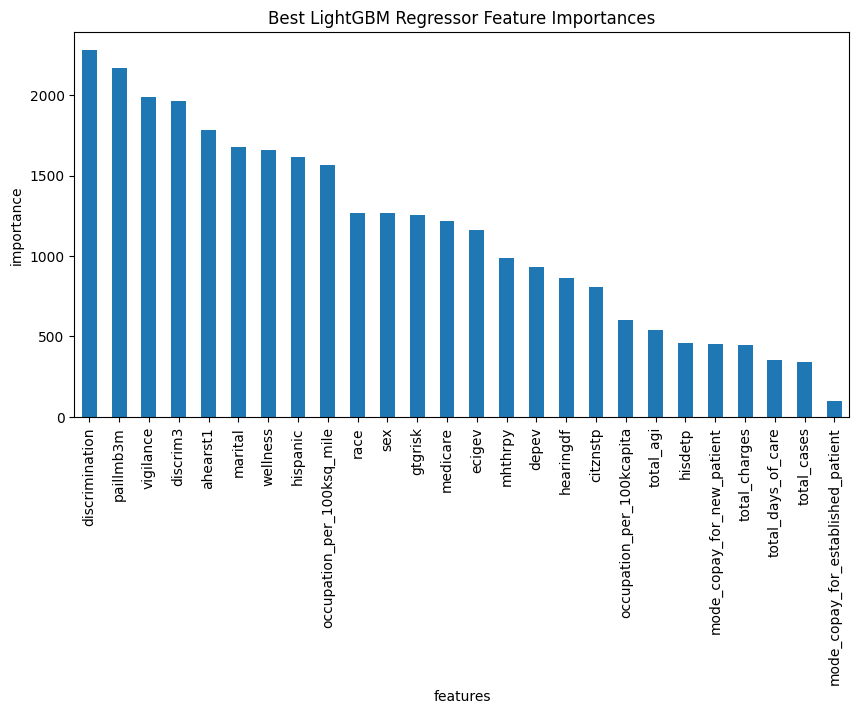

In [88]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`lgbm_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = lgbm_grid_cv.best_estimator_.feature_importances_
lgbm_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
lgbm_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best LightGBM Regressor Feature Importances');

In [89]:
X_train.shape

(54015, 26)

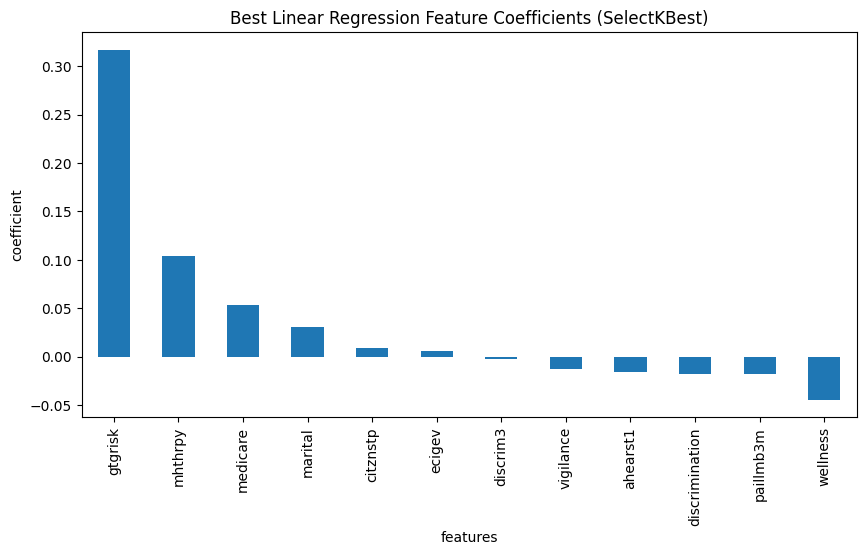

In [90]:
plt.subplots(figsize=(10, 5))

# Get coefficients from the linear regression model
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_

# Get the indices of the selected features
selected_indices = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

# Create a pandas Series for coefficients with the correct index
lr_feat_coefs = pd.Series(coefs, index=X_train.columns[selected_indices]).sort_values(ascending=False)

# Plot the coefficients
lr_feat_coefs.plot(kind='bar')

plt.xlabel('features')
plt.ylabel('coefficient')
plt.title('Best Linear Regression Feature Coefficients (SelectKBest)');

<div class="alert alert-info">We notice that gtgrisk is an important feature in linear regression model performance and random forest model.<br>
    Wellness is at the low end for linear regression model but the most important feature for random forest model.<br>
    LightGBM has wellness and gtgrisk at the middle or lower end, respectively. <br><br>
    Linear Regression → Prefers few dominant features with strong linear relationships.<br>
Random Forest → Balances importance across features, prefers those with high variance reduction.<br>
LightGBM → Focuses on features that improve performance in boosting rounds.<br><br>
    Below the yellow markdown sections, we will evaluate the performance of each model.
</div>

<div class="alert alert-warning">This section in yellow markdown helped us realize that our data set was too large to effectively run on a pc.
  
   Hyperparameter search using RandomizedSearchCV<br><br>
   <strong> We went back and reduced the data and split again for the purpose of the capstone<strong>

</div>

<div class="alert alert-warning">
#Call `RandomizedSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 3-fold cross-validation, and all available CPU cores (if desired)

#Define a custom cross-validator that samples 50% of data in each split
cv_strategy = ShuffleSplit(n_splits=3, train_size=0.5, random_state=42)

rf_random_cv = RandomizedSearchCV(
    RF_pipe, param_distributions=grid_params, 
    n_iter=20, cv=cv_strategy, n_jobs=-1, random_state=42
)
</div>

<div class="alert alert-warning">
#Now call the `RandomizerSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_random_cv.fit(X_train, y_train)
</div>

<div class="alert alert-warning">
#Print the best params (`best_params_` attribute) from the grid search
rf_random_cv.best_params_
</div>

<div class="alert alert-warning">
start_time = time.time()
rf_best_cv_results = cross_validate(rf_random_cv.best_estimator_, X_train, y_train, cv=cv)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Cell execution time: {elapsed_time:.4f} seconds")
</div>

<div class="alert alert-warning">Even with RandomizerSearchCV and ShuffleSplit at 50%, run time takes long.<br>
    Almonst 9 minutes
</div>

<div class="alert alert-warning">np.mean(rf_best_scores), np.std(rf_best_scores)</div>

<div class="alert alert-warning">
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_random_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');
</div>

<div class="alert alert-info"><strong>Final Model Selection</strong>
</div>

<div class="alert alert-info">Linear regression model performance
</div>

In [91]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)


In [92]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(np.float64(0.3179421740200716), np.float64(0.0015420791712984258))

In [93]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

0.32138356855351696

<div class="alert alert-info">Random forest regression model performance
</div>

In [94]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [95]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(np.float64(0.10511274421126408), np.float64(0.0014389468227561095))

In [96]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

0.07747507810146802

<div class="alert alert-info">Grading Boosting Light GBM model performance
</div>

In [97]:
# Perform cross-validation for LightGBM
lgbm_neg_mae = cross_validate(lgbm_grid_cv.best_estimator_, X_train, y_train, 
                              scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [98]:
# Compute mean and standard deviation
lgbm_mae_mean = np.mean(-1 * lgbm_neg_mae['test_score'])
lgbm_mae_std = np.std(-1 * lgbm_neg_mae['test_score'])
lgbm_mae_mean, lgbm_mae_std

(np.float64(0.18957651566727995), np.float64(0.000892466857433782))

In [99]:
# Compute MAE on test set
mean_absolute_error(y_test, lgbm_grid_cv.best_estimator_.predict(X_test))

0.1859172329441017

<div class="alert alert-info">Based on the performance of the three models<br>
    Random forest gives the best mean MAE (CV), the most stable Std Dev MAE (CV), and the best test set MAE.<br><br>
    The choice is to go with random Forest model.
</div>

<div class="alert alert-info"><strong>Data quantity assessment</strong>
</div>

In [100]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe15, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

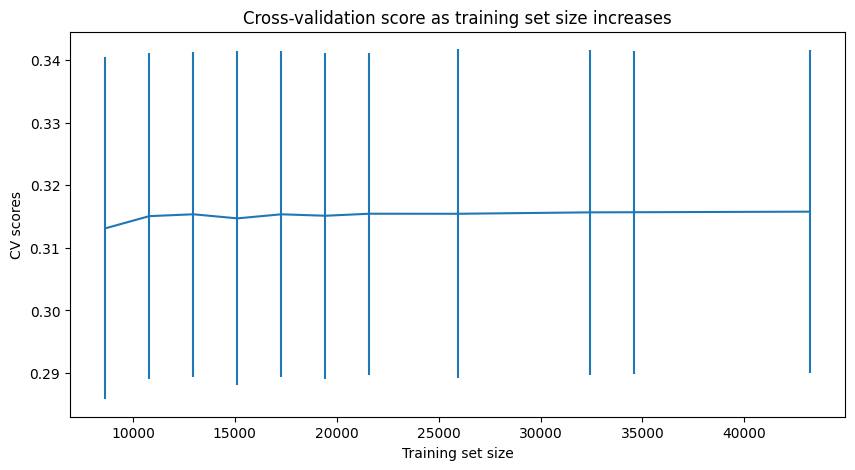

In [101]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

<div class="alert alert-info">We don't need more data to train.<br>
    The flat line suggests no improvement inthe  model score as size increases
</div>

<div class="alert alert-info"><strong>Save best model object from pipeline</strong>
</div>

In [102]:
#This may not be "production grade ML deployment" practice, but adding some basic
#information to your saved models can save your bacon in development.
#Just what version model have you just loaded to reuse? What version of `sklearn`
#created it? When did you make it?
#Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute,
#the numpy version (`np.__version__`) to the `numpy_version` attribute,
#the sklearn version (`sklearn_version`) to the `sklearn_version` attribute,
#and the current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute
#Let's call this model version '1.0'
best_model = rf_grid_cv.best_estimator_

# Add metadata
best_model.metadata = {
    "version": "1.0",
    "pandas_version": pd.__version__,
    "numpy_version": np.__version__,
    "sklearn_version": sklearn.__version__,
    "X_columns": list(X_train.columns),
    "build_datetime": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}


In [103]:
# Save the data 

datapath = '../data'
# Specify the file path for health data
file_path = f'{datapath}/health_record_data.csv'

health_rec.to_csv(file_path, index=False)

# Specify the file path for black race data
file_path = f'{datapath}/black_race_data.csv'

blk_race.to_csv(file_path, index=False)



In [104]:


# Define model path
modelpath = '../models'
os.makedirs(modelpath, exist_ok=True)  # Ensure directory exists

# Define filename
model_filename = os.path.join(modelpath, "health_care_access_model.pkl")

try:
    # Save the model
    joblib.dump(best_model, model_filename)
    
    # Print confirmation
    print(f"✅ Model saved successfully at: {model_filename}")
    
    # Print metadata
    print(f"Model Version: {best_model.metadata['version']}")
    print(f"Built On: {best_model.metadata['build_datetime']}")
    print(f"Features Used: {len(best_model.metadata['X_columns'])} features")
    
except Exception as e:
    print(f"❌ Error saving model: {e}")

#Stop the timer to check the execution time of the notebook.
end_time = time.time()
print(f"Total execution time: {round(end_time - start_time, 2)} seconds")

✅ Model saved successfully at: ../models\health_care_access_model.pkl
Model Version: 1.0
Built On: 2025-03-14 14:54:22
Features Used: 26 features
Total execution time: 1981.84 seconds


## <div class="alert alert-info" align='center'><strong>Conclusion</strong></div>

<div class="alert alert-info">
This notebook is dedicated to modelling access to medical care using machine learning. The baseline model was based on the prediction of the average value of the target, it was the reference point for the assessment of more complex models.

A linear regression model is subsequently built and evaluated. It accounts for approximately 31.98% of the variance in the training data and 31.70% in the test data. Although stable, the model has a high mean absolute error and cannot capture the complexity of the data.

Next, I tried a random forest regressor with median imputation. Cross-validation showed the lowest MAE and standard deviation (0.1052 and 0.0014), meaning the model is both accurate and stable. The test set MAE was 0.0766, indicating good generalization. LightGBM was also tested, and while it outperformed linear regression, its error and variance were higher than random forest.

The random forest model was chosen based on these results as the most accurate and stable. It proved to have the highest overall accuracy, stability, and generalization and was selected as the most reliable choice for predicting access to medical care. The model was trained and saved to be further applied.
</div>